In [ ]:
import numpy as np
import cv2
import os
import matplotlib
from matplotlib import pyplot as plt
import sklearn
from sklearn import metrics

from shutil import copyfile, copy
import re

import keras

In [ ]:
print(cv2.__version__)
print(matplotlib.__version__)
print(sklearn.__version__)
print(keras.__version__)

4.5.4
3.2.2
1.0.2
2.7.0


In [ ]:
#specify data directory and results directory
data_dir = 'drive/MyDrive/DATA'
results_dir = 'drive/MyDrive/RESULTS'

In [ ]:
# mount your local drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define function to read frames from a video

In [ ]:
def read_frames(filename):
    video_cap = cv2.VideoCapture(filename)

    count = 0
    frames = []
    while True:
        success, frame = video_cap.read()

        if success:
            count += 1
            
            # convert from BGR to RGB format
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            frames.append(frame)
        else:
            # print('Failed to read frame') # when last frame read
            break;


    print('Read ', count, ' frames in total')
    video_cap.release()
    
    return frames

### Read frames using above defined function

In [ ]:
frames = read_frames(os.path.join(data_dir, 'video-002.webm'))

Read  524  frames in total


Each frame has shape  (1920, 1080, 3)
module://ipykernel.pylab.backend_inline


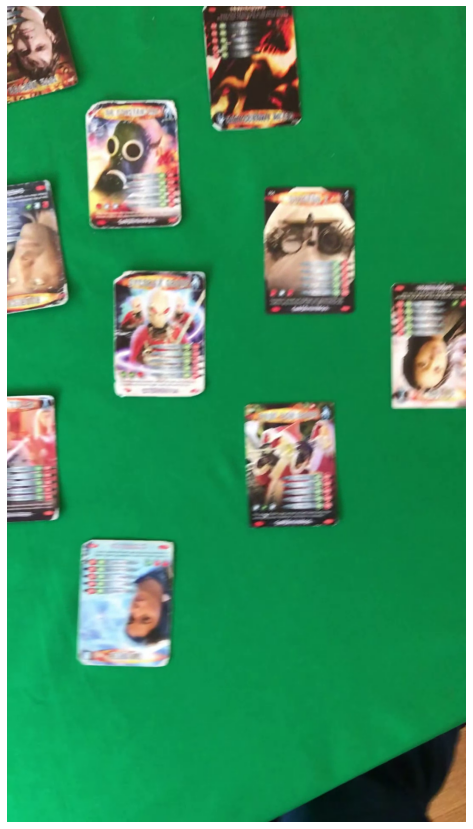

In [ ]:
# display a sample frame
print('Each frame has shape ', frames[0].shape)


print(plt.get_backend())
plt.figure(figsize=(15,15))
plt.imshow(frames[100])
plt.axis('off')
plt.show()

## Define Function to find cards from a given frame

This function employs the same image processing techniques described in `Task-3` to crop out the cards from a given frame. The cropped image is then resized and passed to the CNN model for inference.

In [ ]:
def find_cards(frames, frame_no, pred_model):
    img = frames[frame_no].copy()
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret2,otsu_thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((3,3),np.uint8)
    dilation = cv2.dilate(otsu_thresh,kernel,iterations = 5)

    contours, heirarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    sorted_contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)

    print('#### Model predictions for cropped cards ####')

    for cnt in sorted_contours[:10]:
        perimeter = cv2.arcLength(cnt,True)
        epsilon = 0.01*cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt,epsilon,True)

        rect = cv2.minAreaRect(approx)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        #perspective transform
        width = int(rect[1][0])
        height = int(rect[1][1])
        #print("Area of minAreaRect: ", width*height)
        area_rect = width*height
        
        if area_rect > 100000:
            continue
            
        if area_rect < 20000:
            break

        src_pts = box.astype("float32")
        dst_pts = np.array([[0, height-1],
                            [0, 0],
                            [width-1, 0],
                            [width-1, height-1]], dtype="float32")
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        warped = cv2.warpPerspective(img, M, (width, height))

        plt.figure(figsize=(5,5))
        plt.imshow(warped)
        plt.title('Inference')
        plt.show()
        
        test_img = cv2.resize(warped, (128,128))
        test_img = test_img[None, ...]

        pred = pred_model.predict(test_img)
        pred_class = np.argmax(pred[0])
        print('Predicted Card ID: ', class_id_mapping[pred_class])

### Load trained CNN model from disk

In [ ]:
cnn_model = keras.models.load_model(os.path.join(results_dir, 'cnn_model.h5'))

### Load class_to_id mapping from Pickle file

In [ ]:
import pickle
with open(os.path.join(results_dir, 'class_ID_mapping.pkl'), 'rb') as f:
    class_id_mapping = pickle.load(f)
class_id_mapping

{0: '151',
 1: '010',
 2: '138',
 3: '168',
 4: '061',
 5: '189',
 6: '114',
 7: '109',
 8: '197',
 9: '172',
 10: '039',
 11: '015',
 12: '080',
 13: '157',
 14: '173',
 15: '048',
 16: '033',
 17: '026',
 18: '036',
 19: '063',
 20: '054',
 21: '210',
 22: '052',
 23: '047',
 24: '031',
 25: '018',
 26: '040',
 27: '035',
 28: '005',
 29: '067',
 30: '083',
 31: '068',
 32: '025',
 33: '076',
 34: '057',
 35: '066',
 36: '060',
 37: '089',
 38: '073',
 39: '017',
 40: '056',
 41: '062',
 42: '001',
 43: '069',
 44: '011',
 45: '059',
 46: '096',
 47: '004',
 48: '044',
 49: '065',
 50: '024',
 51: '002',
 52: '028',
 53: '021',
 54: '098',
 55: '037',
 56: '045',
 57: '082',
 58: '042',
 59: '092',
 60: '007',
 61: '142',
 62: '115',
 63: '135',
 64: '101',
 65: '190',
 66: '104',
 67: '124',
 68: '183',
 69: '164',
 70: '087',
 71: '161',
 72: '192',
 73: '177',
 74: '150',
 75: '160',
 76: '146',
 77: '108',
 78: '127',
 79: '198',
 80: '154',
 81: '182',
 82: '186',
 83: '129',
 8

## Call function to get predictions

The function can be called with the frame_number included to crop out the images and run inference with the CNN model.

#### Model predictions for cropped cards ####


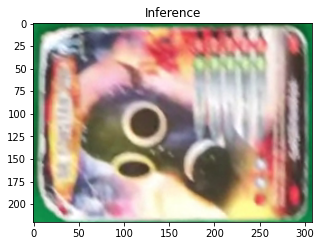

Predicted Card ID:  109


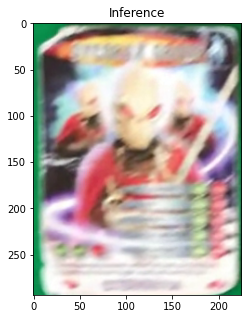

Predicted Card ID:  197


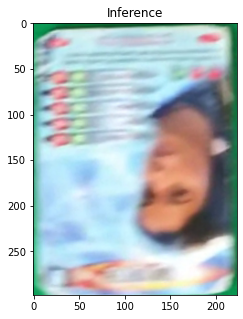

Predicted Card ID:  039


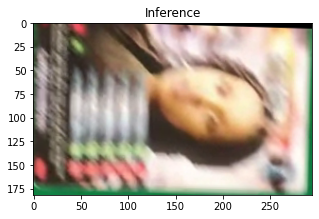

Predicted Card ID:  197


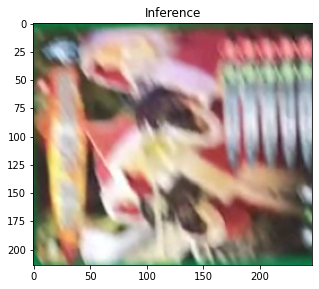

Predicted Card ID:  039


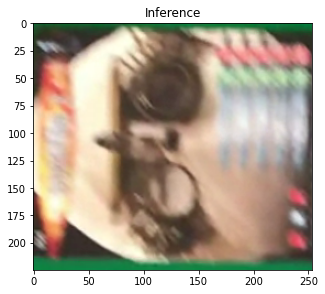

Predicted Card ID:  109


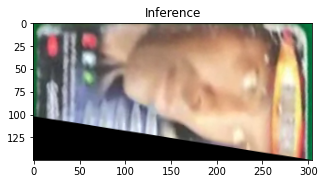

Predicted Card ID:  000


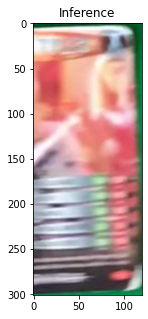

Predicted Card ID:  197


In [ ]:
find_cards(frames, 100, cnn_model)

### Summary
As seen in the above inference results, the model's predictions are not very accurate for many of the cards. There seems to be a big bias towards ID `197` in that many different cards are being predicted as that class.

The correct card_id was only predicted for the third card (Gwyneth - 039). Thus, there is definitely room for improvement with the CNN model. More comprehensive data augmentation techniques can be applied to expand the train set. Additionally, proven CNN architectures such as `ResNet` can be explored to see if those models generalize better!